In [1]:
import sys
sys.executable
sys.version

'3.5.0 (v3.5.0:374f501f4567, Sep 13 2015, 02:16:59) [MSC v.1900 32 bit (Intel)]'

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, monotonically_increasing_id

# Trump's scandals
## Introduction to big data technologies - Final Project

We decided to use New York Times API article\_search (https://developer.nytimes.com/) that enables to look through all the recent articles published and ask for a simple query.
We will do a study case with the key word "Trump".

In [6]:
# IMPORT PART
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
pd.__version__

'0.23.4'

# 1. Collect data
#### 1.1 Do requests to the API and save requests as text file
Usage of an API is somehow limited. That's why we used it once to gather 1000 articles containing the word "Trump" and stored it in a text file.
This API authorizes to download data about only 2000 articles. There is also a restriction on the rate of request, that's why there is a time.sleep(0.5) in the code.
We decided not to collect all the available data about articles, but only the most important features in our opinion. These's 6 features per article we're gonna present later.

In [7]:
# User information
apiKey = "1d71d1495aca41478aa03bbd4a66087b"
# Enter the word you're looking for
query = "Trump"
 
# Build the URL for NYT api
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
url += '?' + 'api-key='+ apiKey + '&q=' + query 
url += "&begin_date=20000101"
url += "&end_date=20181201"
url += "&fl=\"print_page,keywords,pub_date,_id,word_count,score\""
print("url :",url)

url : https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key=1d71d1495aca41478aa03bbd4a66087b&q=Trump&begin_date=20000101&end_date=20181201&fl="print_page,keywords,pub_date,_id,word_count,score"


````

# Do the request : i.e. Download data !
#  Don't use it too much, we have a limited number of requests
# # Limitations of the API : 1000 call per day. 1 call per second.
# 
# # do N requests.
import time
import calendar

apiKey = "1d71d1495aca41478aa03bbd4a66087b"
# Enter the word you're looking for
query = "Trump"
year_start = 2015
year_end = 2018 
nb_of_pages = 1

# Build the URL for NYT api
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
url += '?' + 'api-key='+ apiKey + '&q=' + query 
#url += "&begin_date=20000101"
#url += "&end_date=20181201"
url += "&fl=\"print_page,keywords,pub_date,_id,word_count,score\""
print("url :",url)

#nb_of_articles = 10 * nb_of_pages
with open("data_10000_Trump_6features.txt","w" ) as f:
  for year in range(year_start,year_end+1):
    for month in range(1,13):
      for i in range(nb_of_pages):
        endDay = calendar.monthrange(year,month)[1]
        dateS = "";
        dateE = "";
        if month < 10:
          dateS += str(year) + "0" + str(month) + "01"
          dateE += str(year) + "0" + str(month) + str(endDay)
        if month >= 10:
          dateS += str(year) + "" + str(month) + "01"
          dateE += str(year) + "" + str(month) + str(endDay)


        url0 = url + '&page='+str(i)
        url0 += "&begin_date=" + dateS
        url0 += "&end_date="+ dateE
        time.sleep(1)
        r = requests.get(url0)        
        f.write(json.dumps(r.json())) 
        f.write('\n')

````


#### 1.2 Read the text file
The text file contains 201 lines. Each line is a json containing informations about 10 articles. Each line is (by definition) separated from the next one by a '\n'.

In [8]:
# Define spark session
spark = SparkSession \
    .builder \
    .appName("Test Spark on IntelliJ") \
    .master("local") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [39]:
def load_articles(spark, file_name):

    df = spark.read.json(file_name)
    if df.select("status") == "ERROR":
        return 
    
    df = df.select("response.docs")

    articles = explode(df.docs)
    df = df.select(articles.alias("article"))
    df = df.select("article.*")


    # Retrieve name and value columns from keywords
    keywords = explode(df.keywords)
    df_kw = df.select(df["keywords"].getItem(0).alias("kw"))
    df_kw = df_kw.select("kw.*")

    df_names = df_kw.select(df_kw["name"].alias("keyword_category"))
    df_names = df_names.withColumn("id_name", monotonically_increasing_id())

    df_values = df_kw.select(df_kw["value"].alias("keyword"))
    df_values = df_values.withColumn("id_value", monotonically_increasing_id())

    # Join df with name and value
    df = df.withColumn("id", monotonically_increasing_id())
    df = df.join(df_names, df.id == df_names.id_name)
    df = df.join(df_values, df.id == df_values.id_value)

    # Drop processing columns
    df = df.drop("keywords")
    df = df.drop("id")
    df = df.drop("id_name")
    df = df.drop("id_value")
    return df



file_name = "C:\\Users\\maxim\\Desktop\\BigData\\Articles_Trump-1800.txt"
spark_df = load_articles(spark, file_name)
spark_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- pub_date: string (nullable = true)
 |-- score: double (nullable = true)
 |-- word_count: long (nullable = true)
 |-- keyword_category: string (nullable = true)
 |-- keyword: string (nullable = true)



#### 1.3 Store result in a dataframe

Now that we know what information are available. We select some and stor the most important ones in a dataframe.

We decided to keep :
* score.............: a variable that mesures the relevance of the article
* print\_page..: to see if the article is in the first pages or not
* keywords....: to try to get a bit of a context of the most popular topics
* \_id..................: can be useful if we want to change indeces
* word\_count.: information about the length of the article, which is linked with its relevance.

Precision : this dataset has no NaN value !

In [58]:
#df = pd.DataFrame(data = articles)
df = spark_df.toPandas()
df = df.rename(columns= {'print_page' : 'page',
                         '_id' : 'id',
                         'pub_date' : 'date'})
print("Number of samples :",df.shape[0])
df = df.dropna(how='any', axis=0) 
df.head()


Number of samples : 7873


,id,date,score,word_count,keyword_category,keyword
0,54c66f4e38f0d86e745517a6,2015-01-26T11:44:13Z,3.484666,182,persons,"Trump, Donald J"
2,54aabb4438f0d80bc95942b6,2015-01-05T11:21:17Z,1.049711,355,persons,"Cosby, Bill"
3,54c96c8238f0d8372df4b8c0,2015-01-29T00:00:00Z,0.831144,332,subject,Bridge (Card Game)
4,54b993fb38f0d83735b5a845,2015-01-17T00:00:00Z,0.771642,371,subject,Bridge (Card Game)
5,54b0585538f0d8367c84168d,2015-01-10T00:00:00Z,0.712592,350,subject,Bridge (Card Game)


# 2. Global informations about this dataset

The API give us no control on the articles it gives. It mostly gives recent and relevant article, that's what we're gonna show in this part.

#### 2.1. Publication date : is it approximatively uniform on the whole year ?

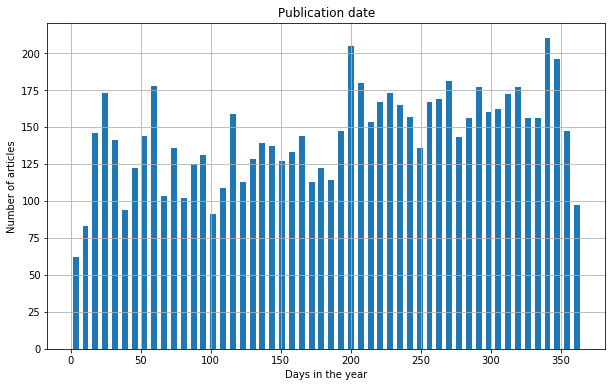

In [59]:
# Let's build an histogram of publication dates


def try_parsing_date(text):
    for fmt in ('%Y-%m-%dT%H:%M:%S+0000', '%Y-%m-%dT%H:%M:%SZ'):
        try:
            return datetime.datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')


def date_to_day_of_the_year(date):
    if type(date)!=type(' '):
        print("Wrong type, str expected.")
        return None
    datetime_object = try_parsing_date(date)
    return datetime_object.timetuple().tm_yday

dates = df.dropna(subset=['date'])['date'].apply(date_to_day_of_the_year).values

plt.figure(figsize=(10,6))
plt.hist(dates,rwidth=0.6,bins = int(365/7),range=(0,365))
plt.grid(True)
plt.xlabel("Days in the year")
plt.ylabel("Number of articles")
plt.title("Publication date")
plt.show()

We suppose that there are more than $2010$ articles with the word "Trump" between 01/01/2018 and 01/12/2018. We have to be careful with this.

#### 2.2. Score : what is the distribution of this score ?

We want to find minimum and maximum of a score, and espacially know what is a big score and how rare it is.

The score is varying between 0.042898808 and 49.75955.
Only the top 0.0% has a score bigger than 70.


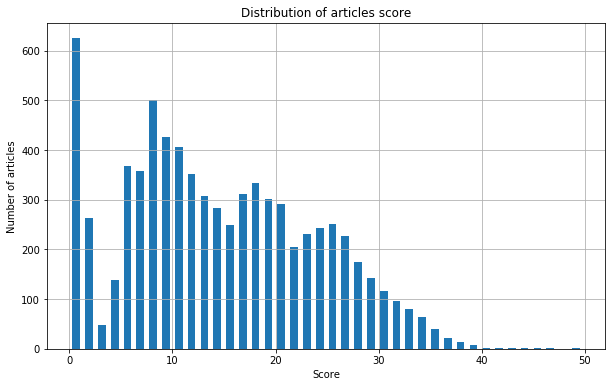

In [60]:
print("The score is varying between",df['score'].min(),"and "+str(df['score'].max())+".")
print("Only the top "+str(round(100*df['score'][df['score']>70].size/df['score'].size,2))+"% has a score bigger than 70.")


plt.figure(figsize=(10,6))
plt.hist(df['score'],bins=40,rwidth=0.6)
plt.xlabel("Score")
plt.ylabel("Number of articles")
plt.title("Distribution of articles score")
plt.grid(True)
plt.show()

We can say that articles with a score bigger than $70$ is relevant and quite rare.

#### 2.3 Word count : how big are the articles ?

The median length of an article is 809.0 words
Only the top 2.31% has more than 2000 words.


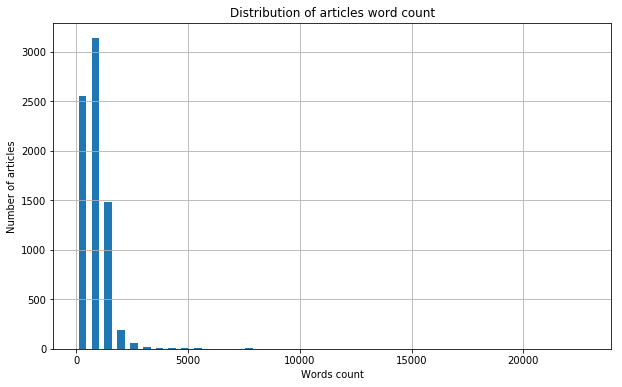

In [61]:
print("The median length of an article is",df['word_count'].median(),"words")
print("Only the top "+str(round(100*df['word_count'][df['word_count']>2000].size/df['word_count'].size,2))+"% has more than 2000 words.")

plt.figure(figsize=(10,6))
plt.hist(df['word_count'],bins=40,rwidth=0.6)
plt.xlabel("Words count")
plt.ylabel("Number of articles")
plt.title("Distribution of articles word count")
plt.grid(True)
plt.show()

#### 2.4 Keywords : let's make a dictionnary with occurences

In [62]:
keywords_df = pd.DataFrame(df['keyword'], columns=['keyword'])
keywords_df['category'] = pd.DataFrame(df['keyword_category'])

def rank_keyword(category,size=10):
    X = np.array(keywords_df).T
    X = X[0][X[1]==category]
    unique, counts = np.unique(X, return_counts=True)
    return pd.DataFrame(np.concatenate((unique.reshape((-1,1)),counts.reshape((-1,1))),axis=1), columns=['keyword','occurences']).sort_values(['occurences'],ascending=False).head(size)

categories = list(keywords_df['category'].unique())
rankings   = {}
for this_category in categories:
    rankings[this_category] = rank_keyword(this_category)

In [46]:
ind = 0
this_category = categories[ind]
print("Ranking of keywords in the category :",this_category)
rankings[this_category]

Ranking of keywords in the category : persons


,keyword,occurences
354,"Trump, Donald J",1481
68,"Bush, Jeb",129
82,"Clinton, Hillary Rodham",125
106,"Cruz, Ted",97
73,"Carson, Benjamin S",68
79,"Christie, Christopher J",39
267,"Obama, Barack",30
36,"Biden, Joseph R Jr",22
358,"Trump, Ivanka",18
195,"Kelly, Megyn",17


In [63]:
ind+=1
print(categories)
this_category = categories[ind]
print("Ranking of keywords in the category :",this_category)
rankings[this_category]

['persons', 'subject', 'glocations', 'organizations', 'type_of_material', 'creative_works', 'unknown']
Ranking of keywords in the category : organizations


,keyword,occurences
83,Republican Party,27
97,Trump Organization,10
32,Federal Bureau of Investigation,9
69,North Atlantic Treaty Organization,7
101,Twitter,7
90,Supreme Court (US),7
34,Federal Reserve System,6
105,United Nations,5
99,"Trump Tower (Manhattan, NY)",5
86,Roman Catholic Church,5


In [64]:
ind+=1
this_category = categories[ind]
print("Ranking of keywords in the category :",this_category)
rankings[this_category]

Ranking of keywords in the category : type_of_material


,keyword,occurences
0,News,18


In [62]:
ind+=1
this_category = categories[ind]
print("Ranking of keywords in the category :",this_category)
rankings[this_category]

Ranking of keywords in the category : organizations


,keyword,occurences
1,Democratic Party,2
2,Federal Reserve System,2
9,Trump Organization,2
0,Central Intelligence Agency,1
3,General Motors,1
4,Google Inc,1
5,Group of Twenty,1
6,Harley-Davidson Inc,1
7,North Atlantic Treaty Organization,1
8,Supreme Court (US),1


# 3. Cross features and draw conclusions

In [65]:
def articles_where_keyword_is(keyword):
    return df.where(df['keyword']==keyword).dropna()

In [66]:
def word_count_comparison(subset,keyword):
    # word count comparison
    plt.figure(figsize=(10,6))
    plt.hist(df['word_count'],bins=100,rwidth=1,density=True,color='navy')
    plt.hist(subset['word_count'],density=subset.shape[0],rwidth=0.3,color='darkorange')
    plt.legend(['total data',keyword])
    # for length in china['word_count']:
    #     plt.vlines(length,ymin=0,ymax=400,color='red')
    plt.xlabel("Words count")
    plt.ylabel("Frequency")
    plt.title("Distribution of articles word count")
    plt.grid(True)
    plt.show()

    subset_mean_word_count = int(subset['word_count'].mean())
    global_mean_word_count = int(df['word_count'].mean())
    if subset_mean_word_count>global_mean_word_count:
        comparison = "greater"
    else:
        comparison = "lower"
    print("* ARTICLE LENGTH")
    print("The mean number of words in the article about "+keyword+" is",subset_mean_word_count,"which is "+comparison+" than the global average ("+str(global_mean_word_count)+").\n")
    pass

def score_comparison(subset,keyword):
    plt.figure(figsize=(10,6))
    plt.hist(df['score'],bins=100,rwidth=1,density=True,color='navy')
    plt.hist(subset['score'],density=True,bins = subset.shape[0],rwidth=0.3,color='darkorange')
    plt.legend(['total data',keyword])
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of articles score")
    plt.grid(True)
    plt.show()

    subset_mean_score = int(subset['score'].mean())
    global_mean_score = int(df['score'].mean())
    if subset_mean_score>global_mean_score:
        comparison = "greater"
    else:
        comparison = "lower"
    print("* ARTICLE RELEVANCE")
    print("The mean score in the article about "+keyword+" is",subset_mean_score,"which is "+comparison+" than the global average ("+str(global_mean_score)+").\n")
    pass

def publication_date_comparison(subset,keyword):
    dates = df.dropna(subset=['date'])['date'].apply(date_to_day_of_the_year).values
    subset_dates = subset.dropna(subset=['date'])['date'].apply(date_to_day_of_the_year).values
    plt.figure(figsize=(10,6))
    plt.hist(dates,rwidth=1,bins = int(365/7),range=(0,365),color='navy',density=True)
    plt.hist(subset_dates,rwidth=0.6,bins = int(365/7),range=(0,365),color='darkorange',density=True)
    plt.grid(True)
    plt.xlabel("Days in the year")
    plt.ylabel("Frequency")
    plt.legend(['total data',keyword])
    plt.title("Publication date")
    plt.show()

    hist, bin_edges = np.histogram(subset_dates)
    peak_day_of_the_year = int(bin_edges[np.argmax(hist)])
    peak_date= (datetime.datetime(2018, 1, 1) + datetime.timedelta(peak_day_of_the_year - 1)).strftime("%d/%m/%Y")
    print("* PUBLICATION DATE")
    print("It seems that there was a news about Trump and "+keyword+" on the",peak_date+".")
    pass


def what_about_this_keyword(keyword):
    subset = articles_where_keyword_is(keyword)

    print("Here is a study case about the articles mentioning Trump whose keyword is :",keyword,"\n")
    word_count_comparison(subset,keyword)
    score_comparison(subset,keyword)
    publication_date_comparison(subset,keyword)
    pass


Here is a study case about the articles mentioning Trump whose keyword is : Russian Interference in 2016 US Elections and Ties to Trump Associates 



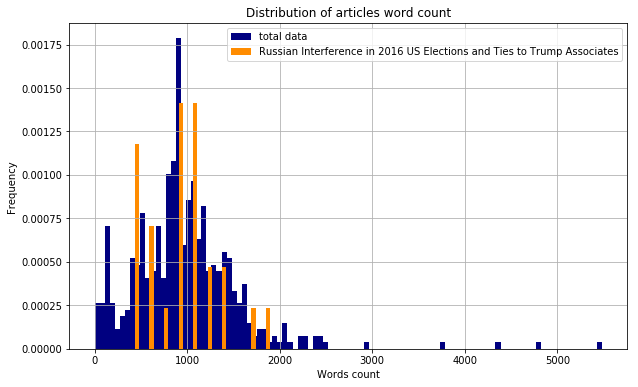

* ARTICLE LENGTH
The mean number of words in the article about Russian Interference in 2016 US Elections and Ties to Trump Associates is 962 which is lower than the global average (977).



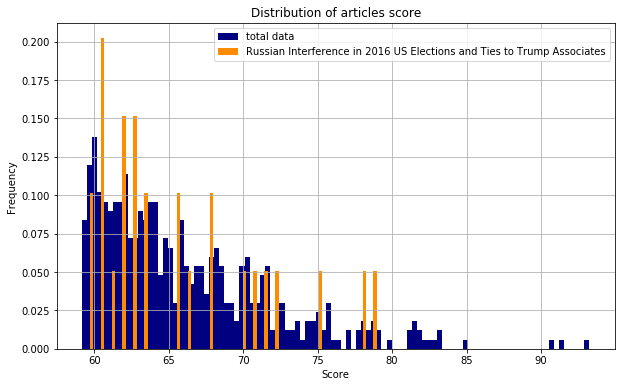

* ARTICLE RELEVANCE
The mean score in the article about Russian Interference in 2016 US Elections and Ties to Trump Associates is 65 which is lower than the global average (66).



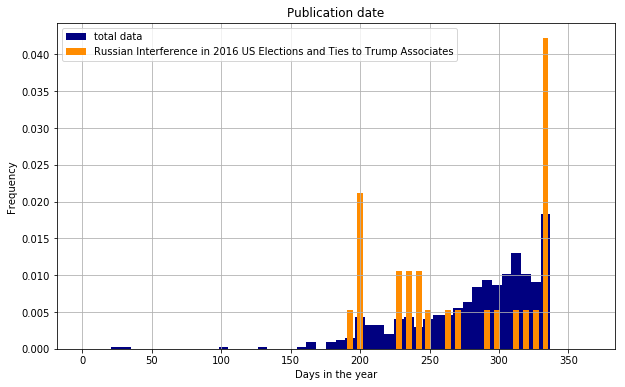

* PUBLICATION DATE
It seems that there was a news about Trump and Russian Interference in 2016 US Elections and Ties to Trump Associates on the 16/11/2018.


In [65]:
what_about_this_keyword(keyword = 'Russian Interference in 2016 US Elections and Ties to Trump Associates')